In [78]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os, sys
import pickle

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import rhinoMorph
rn = rhinoMorph.startRhino()
import warnings
warnings.filterwarnings('ignore')


filepath:  C:\Anaconda3\lib\site-packages
classpath:  C:\Anaconda3\lib\site-packages\rhinoMorph/lib/rhino.jar
JVM is already started~
RHINO started!


In [80]:
class RawData:
    pos = ['NNG','NNP','VV','VA','XR']
    def __init__(self):
        train_data = pd.read_csv('train.csv')
        test_data = pd.read_csv('test.csv')
        
        self.train_img = []
        self.test_img = []
        self.train_text = []
        self.test_text = []
        
        
        with open('./data/한국어불용어100.txt', 'r', encoding='utf-8') as f:
            temp_stopword = f.read().splitlines()
            temp_stopword = list(map(lambda x : x.split('\t'), temp_stopword))

        stop_word = []
        for i in range(len(temp_stopword)):
            stop_word.append(temp_stopword[i][0])
        
        
        for i in tqdm(range(len(train_data))):
            temp = Image.open(train_data['img_path'].iloc[i]).resize((128,128))
            self.train_img.append(np.array(temp))
            
            temp_morph = rhinoMorph.onlyMorph_list(rn, train_data['overview'].iloc[i], pos=RawData.pos)
            joined = []
            for word in temp_morph:
                if word in stop_word:
                    continue
                joined.append(word)
            self.train_text.append(' '.join(joined))
        
        
        for i in tqdm(range(len(test_data))):
            temp = Image.open(test_data['img_path'].iloc[i]).resize((128,128))
            self.test_img.append(np.array(temp))
            
            temp_morph = rhinoMorph.onlyMorph_list(rn, test_data['overview'].iloc[i], pos=RawData.pos)
            joined = []
            for word in temp_morph:
                if word in stop_word:
                    continue
                joined.append(word)
            self.test_text.append(' '.join(joined))
            
        self.target_cat1 = train_data['cat1']
        self.target_cat3 = train_data['cat3']
        
        
            

In [3]:
train_data = pd.read_csv('train.csv')

In [16]:
temp = Image.open(train_data['img_path'].iloc[0])

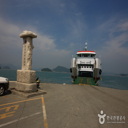

In [21]:
temp.resize((128,128))

In [81]:
data = RawData()

100%|██████████████████████████████████████████████████████████████████████████████| 7280/7280 [01:40<00:00, 72.34it/s]


In [221]:
train_X_text = data.train_text
train_X_img = data.train_img

test_X_text = data.test_text
test_X_img = data.test_img

train_y = data.target_cat3

In [118]:
mask = (np.unique(train_y, return_counts=True)[1] > 10)

In [8]:
pd.Series(train_X_text)

0        소안항 조용 섬 인근 해안 청정 해역 일찍이 김 양식 하 높 소득 올리 있 바다 낚...
1        경기도 이천시 모가면 골프장 대중 홀 회원 개장 하 대중 전환 재개 장 하 총 부지...
2        금오산성 숯불갈비 한우 고기 전문적 취급 사용 부식 자재 또한 유기농법 재배 하 청...
3        철판 위 요리 하 안동 찜 닭 맛보 곳 경상북도 안동시 한식 전문점 대표 메뉴 안동...
4                            영업시간 걸치 아귀 전문 취급 전통 역사 자랑 음식점
                               ...                        
16981                      해발 자리 하 담 카페 점 점 곤드레 밥 감자전 판매 있
16982    설악 힐 호텔 동해고속도로 속초 톨게이트 무엇 관광 있 속초 대표 여행지 청초호 속...
16983    충남 서산시 중심가 위치 하 줌 모텔 프라이 버스 보장 되 조용 공간 가치 높 도심...
16984    토토 크 바위 캠핑장 경기도 가평 지역 내 청정 지역 손꼽히 지역 주변 화악산 봉 ...
16985    포천 진산 불리우 왕방산 천년 역사 간직 왕산사 자리 있 일찍이 도선국 절 창건 머...
Length: 16986, dtype: object

In [196]:
max_words = 15000

In [197]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [198]:
tokenizer = Tokenizer(num_words=max_words)

In [199]:
tokenizer.fit_on_texts(train_X_text)

In [200]:
train_X_token = tokenizer.texts_to_sequences(train_X_text)

In [201]:
train_X_pad = pad_sequences(train_X_token, maxlen=200)

In [202]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Activation, Embedding

In [209]:
class Text_model:
    def __init__(self, max_words, embedding_dimension, length, num_label):
        inputs = Input(shape=(length,))
        emb = Embedding(input_dim = max_words, output_dim = embedding_dimension, input_length = length)(inputs)
        
        lstm1 = LSTM(64, return_sequences = True)(emb)
        drop = Dropout(0.5)
        lstm2 = LSTM(128)(emb)
        drop1 = Dropout(0.5)
        
        dense1 = Dense(256, activation='relu')(lstm2)
        drop2 = Dropout(0.5)(dense1)
        dense2 = Dense(128, activation='relu')(drop2)
        
        outputs = Dense(num_label, activation='softmax')(dense2)
        
        self.model = tf.keras.models.Model(inputs, outputs)

In [210]:
model = Text_model(max_words, 150, 200, 128)

In [211]:
train_X_pad.shape

(16986, 200)

In [222]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)

In [213]:
model.model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [214]:
model.model.fit(train_X_pad, train_y, epochs=100, batch_size=32, validation_split=0.2,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
425/425 [==============================] - 70s 166ms/step - loss: 3.2406 - acc: 0.2711 - val_loss: 2.6689 - val_acc: 0.3670
Epoch 2/100
425/425 [==============================] - 72s 168ms/step - loss: 2.3450 - acc: 0.4299 - val_loss: 2.1525 - val_acc: 0.4732
Epoch 3/100
425/425 [==============================] - 72s 170ms/step - loss: 1.7758 - acc: 0.5344 - val_loss: 2.0218 - val_acc: 0.5324
Epoch 4/100
425/425 [==============================] - 72s 170ms/step - loss: 1.3711 - acc: 0.6197 - val_loss: 1.8301 - val_acc: 0.5653
Epoch 5/100
425/425 [==============================] - 73s 172ms/step - loss: 1.0738 - acc: 0.6919 - val_loss: 1.8911 - val_acc: 0.5954
Epoch 6/100
425/425 [==============================] - 73s 171ms/step - loss: 0.8489 - acc: 0.7492 - val_loss: 1.9999 - val_acc: 0.5951
Epoch 7/100
425/425 [==============================] - 73s 171ms/step - loss: 0.6739 - acc: 0.8009 - val_loss: 2.1758 - val_acc: 0.6015
Epoch 8/100
425/425 [===========================

In [217]:
res = model.model.predict(pad_sequences(tokenizer.texts_to_sequences(test_X_text), maxlen=200))

In [224]:
encoder.classes_

array(['5일장', 'ATV', 'MTB', '강', '게스트하우스', '계곡', '고궁', '고택', '골프', '공연장',
       '공예,공방', '공원', '관광단지', '국립공원', '군립공원', '기념관', '기념탑/기념비/전망대',
       '기암괴석', '기타', '기타행사', '농.산.어촌 체험', '다리/대교', '대중콘서트', '대형서점',
       '도립공원', '도서관', '동굴', '동상', '등대', '래프팅', '면세점', '모텔', '문', '문화관광축제',
       '문화원', '문화전수시설', '뮤지컬', '미술관/화랑', '민물낚시', '민박', '민속마을', '바/까페',
       '바다낚시', '박람회', '박물관', '발전소', '백화점', '번지점프', '복합 레포츠', '분수', '빙벽등반',
       '사격장', '사찰', '산', '상설시장', '생가', '서비스드레지던스', '서양식', '섬', '성',
       '수련시설', '수목원', '수상레포츠', '수영', '스노쿨링/스킨스쿠버다이빙', '스카이다이빙', '스케이트',
       '스키(보드) 렌탈샵', '스키/스노보드', '승마', '식음료', '썰매장', '안보관광', '야영장,오토캠핑장',
       '약수터', '연극', '영화관', '온천/욕장/스파', '외국문화원', '요트', '윈드서핑/제트스키',
       '유람선/잠수함관광', '유명건물', '유스호스텔', '유원지', '유적지/사적지', '이색거리', '이색찜질방',
       '이색체험', '인라인(실내 인라인 포함)', '일반축제', '일식', '자동차경주', '자연생태관광지',
       '자연휴양림', '자전거하이킹', '전문상가', '전시관', '전통공연', '종교성지', '중식', '채식전문점',
       '카약/카누', '카지노', '카트', '컨벤션', '컨벤션센터', '콘도미니엄', '클래식음악회', '클럽',
       '

In [223]:
pd.Series(np.argmax(res[:20], axis=1)).apply(lambda x: encoder.classes_[x])

0            바/까페
1       농.산.어촌 체험
2              한식
3             문화원
4         자연생태관광지
5              한식
6            바/까페
7              한식
8     기념탑/기념비/전망대
9            상설시장
10            공연장
11             한식
12      농.산.어촌 체험
13             사찰
14             한식
15             중식
16           상설시장
17           해수욕장
18              산
19           수련시설
dtype: object

In [98]:
test_X_text[18]

'시무 폭포 규봉암 아래 해발 고도 위치 천연 폭포 전체 높이 강수량 날 규모 폭포 주변 이루 암상 무등산 회 암 이루어지 폭포 규모 상담 중단 하단 단계 나뉘 폭포 중간 각도 내려오 마지막 하단부 떨어지 수직 폭포 형태 장관 이루 시무 지기 무지개 전라도 방언 비 그치 햇살 비추 무지개 뜨 붙이 이름'

In [126]:
mask = np.unique(train_data['cat3'],return_counts=True)[1] < 10

In [128]:
false = encoder.classes_[mask]

In [140]:
false_idx = None
for i in false:
    temp = train_data['cat3'] == i
    if false_idx is None:
        false_idx = temp.values
    false_idx = temp.values | false_idx

In [167]:
mask = pd.Series(false_idx).apply(lambda x : not x).values

In [168]:
de_train_X = np.array(train_X_text)[mask]

In [169]:
de_train_y = np.array(train_data['cat3'])[mask]

In [170]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(de_train_X)

de_train_X_token = tokenizer.texts_to_sequences(de_train_X)

de_train_X_pad = pad_sequences(de_train_X_token, maxlen=150)

In [171]:
de_encoder = LabelEncoder()
de_train_y = de_encoder.fit_transform(de_train_y)

In [172]:
temp_m = Text_model(max_words, 200, 150, len(de_encoder.classes_))

In [173]:
temp_m.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [174]:
temp_m.model.fit(de_train_X_pad, de_train_y, epochs=100, validation_split=0.2, batch_size=32,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/100
422/422 [==============================] - 60s 143ms/step - loss: 3.1445 - acc: 0.2844 - val_loss: 2.5747 - val_acc: 0.3682
Epoch 2/100
422/422 [==============================] - 63s 149ms/step - loss: 2.2388 - acc: 0.4330 - val_loss: 2.0744 - val_acc: 0.4573
Epoch 3/100
422/422 [==============================] - 63s 149ms/step - loss: 1.6578 - acc: 0.5440 - val_loss: 1.8864 - val_acc: 0.5466
Epoch 4/100
422/422 [==============================] - 63s 149ms/step - loss: 1.2540 - acc: 0.6421 - val_loss: 1.8971 - val_acc: 0.5653
Epoch 5/100
422/422 [==============================] - 63s 148ms/step - loss: 0.9487 - acc: 0.7210 - val_loss: 1.8697 - val_acc: 0.6027
Epoch 6/100
422/422 [==============================] - 62s 147ms/step - loss: 0.6963 - acc: 0.7886 - val_loss: 1.9841 - val_acc: 0.6050
Epoch 7/100
422/422 [==============================] - 62s 148ms/step - loss: 0.5324 - acc: 0.8404 - val_loss: 2.2480 - val_acc: 0.6056
Epoch 8/100
422/422 [===========================

In [159]:
len(de_train_X_pad)

139

In [177]:
re = temp_m.model.predict(pad_sequences(tokenizer.texts_to_sequences(test_X_text), maxlen=150))

In [193]:
result_re = pd.Series(np.argmax(re, axis=1)).apply(lambda x:de_encoder.classes_[x])

In [194]:
submit = pd.read_csv('sample_submission.csv')
submit['cat3'] = result_re
submit.to_csv('submit_1017.csv', index=False)

In [186]:
under = np.unique(train_data['cat3'], return_counts=True)[1]<10
over = np.unique(train_data['cat3'], return_counts=True)[1]>10

In [185]:
np.unique(train_data['cat3'], return_counts=True)[0][under]

array(['ATV', 'MTB', '대중콘서트', '면세점', '뮤지컬', '발전소', '백화점', '번지점프', '분수',
       '빙벽등반', '사격장', '스노쿨링/스킨스쿠버다이빙', '스카이다이빙', '스키/스노보드', '연극', '영화관',
       '외국문화원', '이색체험', '인라인(실내 인라인 포함)', '전통공연', '카지노', '카트', '클래식음악회',
       '클럽', '터널', '학교', '헹글라이딩/패러글라이딩'], dtype=object)

In [187]:
np.unique(train_data['cat3'], return_counts=True)[0][over]

array(['5일장', '강', '게스트하우스', '계곡', '고궁', '고택', '골프', '공연장', '공예,공방', '공원',
       '관광단지', '국립공원', '군립공원', '기념관', '기념탑/기념비/전망대', '기암괴석', '기타', '기타행사',
       '농.산.어촌 체험', '다리/대교', '대형서점', '도립공원', '도서관', '동굴', '동상', '등대',
       '래프팅', '모텔', '문', '문화관광축제', '문화원', '문화전수시설', '미술관/화랑', '민물낚시',
       '민박', '민속마을', '바/까페', '바다낚시', '박람회', '박물관', '복합 레포츠', '사찰', '산',
       '상설시장', '생가', '서비스드레지던스', '서양식', '섬', '성', '수련시설', '수목원', '수상레포츠',
       '수영', '스케이트', '스키(보드) 렌탈샵', '승마', '썰매장', '안보관광', '야영장,오토캠핑장',
       '약수터', '온천/욕장/스파', '요트', '윈드서핑/제트스키', '유람선/잠수함관광', '유명건물', '유스호스텔',
       '유원지', '유적지/사적지', '이색거리', '이색찜질방', '일반축제', '일식', '자동차경주',
       '자연생태관광지', '자연휴양림', '자전거하이킹', '전문상가', '전시관', '종교성지', '중식', '채식전문점',
       '컨벤션', '컨벤션센터', '콘도미니엄', '테마공원', '트래킹', '특산물판매점', '패밀리레스토랑', '펜션',
       '폭포', '한식', '한옥스테이', '항구/포구', '해수욕장', '해안절경', '헬스투어', '호수', '홈스테이',
       '희귀동.식물'], dtype=object)